# Developing a Women's Pro Hockey Expected Goals (xG) Model

#### Brian Johns, February 2026

## Notebook #2: Feature Engineering & EDA

In notebook #1, I collected, merged and cleaned the data.  However, it is apparent that some feature engineering will be required in order to provide a stronger signal for the model.  Some features were added that have been known to strengthen xG models, while others were developed through the course of Exploratory Data Analysis.

In this notebook, I will do the following:

1. [Load Data and Set-Up](#loading)
2. [Feature Engineering](#features)
3. [Exploratory Data Analysis](#eda)
4. [Prep Data For Modelling](#prepping)

In [1]:
import requests
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from matplotlib.patches import Polygon as MplPolygon

import matplotlib.patches as patches
import json
import time
from collections import Counter

from shapely.geometry.polygon import Polygon

from shapely.geometry import Point

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

<a id = 'loading'></a>

## 1. Load Data and Set-Up

As part of this project, I wanted to explore customizing my visuals.  In this case I have customized them to reflect the color scheme of the PWHL, while still making the visuals interpretable.

In [2]:
PWHL = {
    "purple":    "#6B3FA0",
    "purple_lt": "#9B6FD0",
    "purple_dk": "#3D1F6B",
    "gold":      "#C4952A",
    "goal_red":  "#C0394A",
    "silver":    "#4A4460",
    "muted":     "#C8C2D8",
    "bg":        "#EDEAF2",
    "bg2":       "#F7F5FA",
    "white":     "#FFFFFF",
}

def pwhl_theme():
    """Apply PWHL seaborn theme globally."""
    sns.set_theme(style="whitegrid", rc={
        "axes.facecolor":    PWHL["bg2"],
        "figure.facecolor":  PWHL["bg"],
        "axes.edgecolor":    PWHL["muted"],
        "axes.labelcolor":   PWHL["silver"],
        "grid.color":        PWHL["muted"],
        "grid.linewidth":    0.6,
        "xtick.color":       PWHL["silver"],
        "ytick.color":       PWHL["silver"],
        "text.color":        PWHL["silver"],
        "font.family":       "monospace",
        "axes.spines.top":   False,
        "axes.spines.right": False,
    })

def _add_title_block(fig, title, subtitle=""):
    title_y = 0.97
    fig.text(0.05, title_y, title,
             color=PWHL["purple_dk"], fontsize=16, fontweight="bold",
             fontfamily="monospace", va="top")
    if subtitle:
        fig.text(0.05, title_y - 0.052, subtitle,
                 color=PWHL["purple"], fontsize=12,
                 fontfamily="monospace", va="top")
    bar = fig.add_axes([0.05,
                        title_y - 0.010 - (0.018 if subtitle else 0.005),
                        0.4, 0.003])
    bar.set_facecolor(PWHL["purple"])
    bar.axis("off")
    fig.text(0.98, 0.01, "PWHL xG Model",
             color=PWHL["muted"], fontsize=7,
             fontfamily="monospace", ha="right", va="bottom")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.tight_layout(rect=[0, 0.02, 1, 0.88])
    plt.close()   # ← prevents Jupyter auto-display


def pwhl_bar(df=None, x=None, y=None, data=None,
             title="", subtitle="", xlabel="", ylabel="",
             highlight=None, figsize=(10, 5), horizontal=False, show=False):
    """
    Bar chart with two calling styles:

    Style 1 — pass a raw DataFrame and column names, aggregation is automatic:
        pwhl_bar(df=df, x='home_team', y='is_goal', ...)

    Style 2 — pass a pre-aggregated pd.Series:
        series = df.groupby('home_team')['is_goal'].mean()
        pwhl_bar(data=series, ...)
    """
    pwhl_theme()

    # Resolve into a plain Series
    if df is not None and x is not None and y is not None:
        data   = df.groupby(x)[y].mean()
        xlabel = xlabel or x
        ylabel = ylabel or f"Mean {y}"
    elif data is None:
        raise ValueError("Pass either (df, x, y) or a pre-aggregated data= Series.")

    fig, ax = plt.subplots(figsize=figsize, facecolor=PWHL["bg"])
    ax.set_facecolor(PWHL["bg2"])

    cats   = data.index.astype(str).tolist()
    vals   = data.values.tolist()
    colors = [PWHL["gold"] if c == str(highlight) else PWHL["purple"] for c in cats]

    if horizontal:
        ax.barh(cats, vals, color=colors,
                edgecolor=PWHL["white"], linewidth=0.6, alpha=0.88)
        ax.set_xlabel(ylabel or "Value")
        ax.set_ylabel(xlabel or "")
        for i, v in enumerate(vals):
            ax.text(v + max(vals)*0.01, i,
                    f"{v:.3f}", va="center", color=PWHL["silver"], fontsize=10)
    else:
        ax.bar(cats, vals, color=colors,
               edgecolor=PWHL["white"], linewidth=0.6, alpha=0.88)
        ax.set_xlabel(xlabel or "")
        ax.set_ylabel(ylabel or "Value")
        for i, v in enumerate(vals):
            ax.text(i, v + max(vals)*0.01,
                    f"{v:.3f}", ha="center", color=PWHL["silver"], fontsize=10)
        ax.tick_params(axis="x", rotation=35)

    _add_title_block(fig, title, subtitle)
    if show:
        display(fig)
        plt.close(fig)
    return fig

def pwhl_hist(series, title, subtitle="", xlabel="", ylabel="Count",bins=40, stat = "count", line=False, figsize=(10, 5)):
    """Histogram with KDE overlay and mean line."""
    pwhl_theme()
    fig, ax = plt.subplots(figsize=figsize, facecolor=PWHL["bg"])
    ax.set_facecolor(PWHL["bg2"])
    sns.histplot(series.dropna(), bins=bins, kde=line, stat = stat,
                 color=PWHL["purple"], edgecolor=PWHL["white"],
                 linewidth=0.4, alpha=0.85,
                 line_kws={"color": PWHL["purple_lt"], "linewidth": 2}, ax=ax)
    ax.axvline(series.mean(), color=PWHL["gold"], linewidth=2,
                   linestyle="--", label=f"Mean: {series.mean():.2f}")
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=9)
    ax.set_xlabel(xlabel or series.name or "")
    ax.set_ylabel(ylabel)
    _add_title_block(fig, title, subtitle)
    plt.tight_layout(rect=[0, 0.02, 1, 0.88])
    return fig


def pwhl_scatter(df, x, y, color_by=None, title="", subtitle="",
                 xlabel=None, ylabel=None, figsize=(10, 6), show=False):
    pwhl_theme()
    fig, ax = plt.subplots(figsize=figsize, facecolor=PWHL["bg"])
    ax.set_facecolor(PWHL["bg2"])

    if color_by and color_by in df.columns:
        # Plot 0s first (background layer)
        mask_0 = df[color_by] == 0
        mask_1 = df[color_by] == 1
        ax.scatter(df.loc[mask_0, x], df.loc[mask_0, y],
                   color=PWHL["purple"], s=12, alpha=0.5,
                   edgecolors="none", label="No Goal", zorder=2)
        # Goals on top — larger, opaque, gold
        ax.scatter(df.loc[mask_1, x], df.loc[mask_1, y],
                   color=PWHL["gold"], s=24, alpha=0.9,
                   edgecolors=PWHL["purple_dk"], linewidths=0.4,
                   label="Goal", zorder=3)
    else:
        ax.scatter(df[x], df[y], color=PWHL["purple"],
                   s=15, alpha=0.5, edgecolors="none")

    ax.set_xlabel(xlabel or x)
    ax.set_ylabel(ylabel or y)
    ax.legend(facecolor=PWHL["white"], edgecolor=PWHL["muted"],
              labelcolor=PWHL["silver"], fontsize=9)
    _add_title_block(fig, title, subtitle)
    if show:
        display(fig)
        plt.close(fig)
    return fig

In [3]:
# Loading Data from previous notebook
df = pd.read_csv('all_shots.csv')

In [4]:
# Through EDA, it was shown that Montreal was labeled differently in different seasons in the PWHL
df.loc[df['home_team'] == 'MON', 'home_team'] = 'MTL'
df.loc[df['away_team'] == 'MON', 'away_team'] = 'MTL'
df.loc[df['player_team'] == 'MON', 'player_team'] = 'MTL'
df.loc[df['goalie_team'] == 'MON', 'goalie_team'] = 'MTL'

An issue that arose in EDA is that there were a number of shots that showed to have 6 Skaters for the `home_team_skaters` AND `away_team_skater`.  Unfortunately there are a few issues with this:
- Having 6 skaters on for both teams does not happen in regular play
- All of these are ONLY goals, suggesting a 100% goal rate with 6 skaters on
- All of the goals scored have a goalie in the net, and therefore unlikely to be Empty Net goals

My assumption is that these were goals scored by the attacking team when they pulled their goalie for an extra skater.  However, the opposing team were incorrectly identified to have 6 skaters on the ice as well, and the data did not track shots that were saved in this situation.

I have decided to keep these as part of the data, but to change it to 5-on-5.  It is likely that the saves in the pulled goalie situation are still listed as 5-on-5, and 5-on-5 still best describes the situation given that neither team is penalized at this point.  Better player tracking data in the future could help solve this issue, but for now I will include the data with the correction.

In [5]:
df.loc[df['home_team_skaters'] == 6, 'home_team_skaters'] = 5
df.loc[df['away_team_skaters'] == 6, 'away_team_skaters'] = 5

<a id = 'features'></a>

## 2. Feature Engineering

### Team Score and Goal Differential

The shot data did not have the live score in the PWHL data, so we will be recreating the score here.  The result has been checked against real world results to ensure accuracy.

With the goal differential, we can also simplify it to whether the shooter's team was `winning`, `losing` or `tied`

In [6]:
# Recreating the score for the game
df['home_goal'] = (df['is_goal']) & (df['player_team'] == df['home_team'])
df['away_goal'] = (df['is_goal']) & (df['player_team'] == df['away_team'])
df['home_score'] = df.groupby(['source', 'game_id'])['home_goal'].cumsum()
df['away_score'] = df.groupby(['source', 'game_id'])['away_goal'].cumsum()
df['home_score'] = df.groupby(['source', 'game_id'])['home_score'].shift(1).fillna(0).astype(int)
df['away_score'] = df.groupby(['source', 'game_id'])['away_score'].shift(1).fillna(0).astype(int)

# End up with Goal Differential
df['goal_diff'] = np.where(
    df['player_team'] == df['home_team'],
    df['home_score'] - df['away_score'],
    df['away_score'] - df['home_score']
)

# Generalizing goal_diff into different states for the team that is shooting
df['score_state'] = np.where(df['goal_diff'] == 0, 'tied',
                       np.where(df['goal_diff'] > 0, 'winning', 'losing'))
df = pd.get_dummies(df, columns=['score_state'], prefix='', prefix_sep='')

### Skater Differential & Strength State

In [7]:
# PP, ES and SH are not labeled on data, need to manufacture it
df['skater_diff'] = np.where(
    df['player_team'] == df['home_team'],
    df['home_team_skaters'] - df['away_team_skaters'],
    df['away_team_skaters'] - df['home_team_skaters']
)
df['strength_state'] = np.where(df['skater_diff'] == 0, 'es',
                       np.where(df['skater_diff'] > 0, 'pp', 'sh'))
df = pd.get_dummies(df, columns=['strength_state'], prefix='', prefix_sep='')

### Rebounds

A previously noted issue with the data is that some shot tracking has multiple shots, up to 5 or 6 shots, happening simultaneously in the same second of `game_time`, at various places on the ice that would make the number of shots impossible (not just players getting multiple rebounds in close).

A recorded way to have this feature is to record any shot that happens 2 seconds are less after the shot preceding it.  Given this issue, I have limited it to occuring more than 0 seconds but less 2 seconds after the initial shot.  This may miss some shots that happen during the same second of `game_time` but will lessen the impact of shots erroneously being recorded in the same second.

In [8]:
df['prev_game_time'] = df.groupby(['source', 'game_id'])['game_time'].shift(1)
df['time_since'] = df['game_time'] - df['prev_game_time']
df['rebound'] = np.where(((df['time_since'] > 0) & (df['time_since'] <= 2)), 1, 0)

## One-hot Encoding Periods

In [9]:
df = pd.get_dummies(df, columns=['period'], prefix = 'period_', prefix_sep = '')

In [10]:
df

,source,game_id,is_goal,home_team,away_team,home_team_skaters,away_team_skaters,player_name,position,player_team,goalie_name,goalie_team,game_time,x_ft,y_ft,dist_ft,angle_deg,shot_type,home_goal,away_goal,home_score,away_score,goal_diff,losing,tied,winning,skater_diff,es,pp,sh,prev_game_time,time_since,rebound,period_1,period_2,period_3
0,PWPHA,1,0,Harvey's,Adidas,5,5,Hayley Scamurra,F,Harvey's,Ann-Renée Desbiens,Adidas,30.266666,75.142281,15.844118,21.0,48.8,snapshot,False,False,0,0,0,0,1,0,0,1,0,0,NaN,NaN,0,1,0,0
1,PWPHA,1,0,Harvey's,Adidas,5,5,Sarah Potomak,F,Adidas,Maddie Rooney,Harvey's,57.900000,81.272430,-0.252941,7.7,1.9,snapshot,False,False,0,0,0,0,1,0,0,1,0,0,30.266666,27.633334,0,1,0,0
2,PWPHA,1,0,Harvey's,Adidas,5,5,Kendall Coyne Schofield,F,Adidas,Maddie Rooney,Harvey's,134.866670,85.295959,-36.464706,36.7,84.2,snapshot,False,False,0,0,0,0,1,0,0,1,0,0,57.900000,76.966670,0,1,0,0
3,PWPHA,1,0,Harvey's,Adidas,5,5,Laura Fortino,D,Harvey's,Ann-Renée Desbiens,Adidas,298.133330,67.598160,0.252941,21.4,0.7,wristshot,False,False,0,0,0,0,1,0,0,1,0,0,134.866670,163.266660,0,1,0,0
4,PWPHA,1,0,Harvey's,Adidas,5,5,Lee Stecklein,D,Harvey's,Ann-Renée Desbiens,Adidas,301.500000,43.458725,-32.444130,55.9,35.5,wristshot,False,False,0,0,0,0,1,0,0,1,0,0,298.133330,3.366670,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,PWHL,337,0,MTL,BOS,5,5,Megan Keller,D,BOS,Sandra Abstreiter,MTL,3041.000000,70.000000,-20.429825,27.9,47.1,Slap,False,False,3,1,-2,1,0,0,0,1,0,0,2989.000000,52.000000,0,0,0,1
16684,PWHL,337,0,MTL,BOS,4,5,Jamie Lee Rattray,F,BOS,Sandra Abstreiter,MTL,3261.000000,71.333333,-0.447368,17.7,1.5,Tip,False,False,3,1,-2,1,0,0,1,0,1,0,3041.000000,220.000000,0,0,0,1
16685,PWHL,337,0,MTL,BOS,4,5,Jamie Lee Rattray,F,BOS,Sandra Abstreiter,MTL,3265.000000,75.000000,2.236842,14.2,9.1,Backhand,False,False,3,1,-2,1,0,0,1,0,1,0,3261.000000,4.000000,0,0,0,1
16686,PWHL,337,0,MTL,BOS,5,5,Laura Stacey,F,MTL,Amanda Thiele,BOS,3341.000000,73.333333,5.517544,16.6,19.4,Tip,False,False,3,1,2,0,0,1,0,1,0,0,3265.000000,76.000000,0,0,0,1


### One-hot Encoding Shot Types

In [11]:
# Formatting and one-hot encoding shot types
df['shot_type'] = df['shot_type'].str.lower()
df.loc[df['shot_type'] == 'wristshot', 'shot_type'] = 'wrist'
df.loc[df['shot_type'] == 'snapshot', 'shot_type'] = 'snap'
df.loc[df['shot_type'] == 'slapshot', 'shot_type'] = 'slap'
df.loc[df['shot_type'] == 'deflected', 'shot_type'] = 'tip'
df.loc[(df['shot_type'] == 'default')|(df['shot_type'] == 'wraparound'), 'shot_type'] = 'other'
df = pd.get_dummies(df, columns=['shot_type'], prefix = '', prefix_sep = '')

### Slot Shots

Re-used Polygon in order to determine whether a shot occured from the slot.

In [12]:
# Using Polygon to determine whether the shot took place in the Slot
slot_coor = [(54, 22), (54, -22), (89, -3), (89, 3)]
slot = Polygon(slot_coor)
df['slot'] = df.apply(
    lambda row: int(slot.contains(Point(row['x_ft'], row['y_ft']))),
    axis=1)

### Arc Length

As a way to interpret `dist_ft` and `angle_deg` together.

In [13]:
# Arc Length of the shot to simultaneously take distance and angle into consideration
df['arclength'] = (df['dist_ft']*df['angle_deg']*np.pi)/180

### Late & Close Games

In [14]:
# Indications showed that there was a difference between when a game was close and not
df['close_game'] = np.where(abs(df['goal_diff']) <= 1, 1, 0)

# Defining when it is late in the game (last 5 minutes) to take fatigue into consideration, particularly for goalies
df['late_game'] = np.where(df['game_time'] > 3300, 1, 0)

### Position & League Info

In [15]:
# Set-up boolean for Forwards (vs Defence)
df['is_forward'] = np.where(df['position'] == "F", 1, 0)

# Boolean for the league
df['pwhl'] = np.where(df['source'] == "PWHL", 1, 0)

### Absolute Value of Y-Axis

`y_ft` 'zeroes' at the center of the ice, with positive numbers being to the right of the goalie and negative numbers being to the left.  The center of the ice is generally a more dangerous scoring position, so taking the absolute valye of `y_ft` should be negatively correlated to `is_goal` (the closer to 0/the middle, the better the goal rate)

In [16]:
# Getting an absolute value for the Y-axis.  0 is the center and likely to be the highest percentage
df['y_abs'] = abs(df['y_ft'])

### Skater & Goalie Quality

An initial thought was to take a bayesian approach in order to determine shooter and goalie quality.  We could use the overall goal rate/save percentage to establish an initial prior, and then update each individual's quality as they progress through the seasons.  This should then update as the games progress chronologically which should reflect the player's recent quality, whereas those with very few shots will stay close to the overall average.

In [17]:
LEAGUE_AVG  = df['is_goal'].mean()
PRIOR_SHOTS = 30

def bayesian_rate(goals, shots, prior_rate, prior_shots):
    """
    Shrink observed rate toward prior using Bayesian updating.
    With few shots, returns close to prior_rate.
    With many shots, returns close to observed rate.
    """
    return (goals + prior_rate * prior_shots) / (shots + prior_shots)


# --- Shooter quality ---
# For each shot, compute shooter's goal rate on all PRIOR shots only
df['shooter_quality'] = 0.0

shooter_goals  = {}   # running totals per player
shooter_shots  = {}

for idx, row in df.iterrows():
    name = row['player_name']
    
    # Assign quality BEFORE updating with this shot
    g = shooter_goals.get(name, 0)
    s = shooter_shots.get(name, 0)
    df.at[idx, 'shooter_quality'] = bayesian_rate(g, s, LEAGUE_AVG, PRIOR_SHOTS)
    
    # Now update running totals
    shooter_shots[name]  = s + 1
    shooter_goals[name]  = g + row['is_goal']


# --- Goalie quality (save percentage prior) ---
GOALIE_PRIOR_RATE  = 1 - LEAGUE_AVG   # Changing into Save Pct rather than Goal Rate
GOALIE_PRIOR_SHOTS = 50               # Goalies more prone to fluctuations, so bigger prior number

df['goalie_save_pct'] = 0.0

goalie_saves = {}
goalie_shots = {}

for idx, row in df.iterrows():
    name = row['goalie_name']
    if pd.isna(name):
        df.at[idx, 'goalie_save_pct'] = GOALIE_PRIOR_RATE
        continue

    g = goalie_saves.get(name, 0)
    s = goalie_shots.get(name, 0)
    df.at[idx, 'goalie_save_pct'] = bayesian_rate(g, s, GOALIE_PRIOR_RATE, GOALIE_PRIOR_SHOTS)

    # Update: a save = not a goal
    goalie_shots[name] = s + 1
    goalie_saves[name] = g + (1 - row['is_goal'])


print(f"Shooter quality range: {df['shooter_quality'].min():.3f} to {df['shooter_quality'].max():.3f}")
print(f"Goalie save pct range: {df['goalie_save_pct'].min():.3f} to {df['goalie_save_pct'].max():.3f}")
print(f"\nTop 5 shooters by quality:")
print(df.groupby('player_name')['shooter_quality'].last().sort_values(ascending=False).head(5))
print(f"\nTop 5 goalies by save pct:")
print(df.groupby('goalie_name')['goalie_save_pct'].last().sort_values(ascending=False).head(5))

Shooter quality range: 0.023 to 0.180
Goalie save pct range: 0.862 to 0.960

Top 5 shooters by quality:
player_name
Britta Curl-Salemme     0.148379
Brooke McQuigge         0.141337
Kristýna Kaltounková    0.139976
Natasza Tarnowski       0.134475
Marie-Philip Poulin     0.133442
Name: shooter_quality, dtype: float64

Top 5 goalies by save pct:
goalie_name
Shea Tiley          0.942108
Sydney Scobee       0.937497
Erica Howe          0.936005
Aerin Frankel       0.928881
Lindsay Browning    0.928011
Name: goalie_save_pct, dtype: float64


This provided a good 'running' quality, but we will also take just the last value and apply it to all of that players shots.  This won't 'change' through the seasons, but may be a better reflection of the quality, especially given the relatively short time span (3-4 seasons) of the data.

Creating 'career' quality features would introduce some data leakage into the 'running' features, so only one should be used during modeling.

In [18]:
career_shooters = (df.groupby('player_name')['shooter_quality'].last()
                                .rename('shooter_career_quality'))

df = df.merge(career_shooters, on='player_name', how='left')

career_goalies = (df.groupby('goalie_name')['goalie_save_pct'].last()
                                .rename('goalie_career_save_pct'))

df = df.merge(career_goalies, on='goalie_name', how='left')

In [19]:
# Dropping all unnecessary columns after getting dummies
df = df.drop(columns=['prev_game_time', 'time_since', 'home_goal', 'away_goal', 'position'])

In [20]:
df.head()

,source,game_id,is_goal,home_team,away_team,home_team_skaters,away_team_skaters,player_name,player_team,goalie_name,goalie_team,game_time,x_ft,y_ft,dist_ft,angle_deg,home_score,away_score,goal_diff,losing,tied,winning,skater_diff,es,pp,sh,rebound,period_1,period_2,period_3,backhand,other,slap,snap,tip,wrist,slot,arclength,close_game,late_game,is_forward,pwhl,y_abs,shooter_quality,goalie_save_pct,shooter_career_quality,goalie_career_save_pct
0,PWPHA,1,0,Harvey's,Adidas,5,5,Hayley Scamurra,Harvey's,Ann-Renée Desbiens,Adidas,30.266666,75.142281,15.844118,21.0,48.8,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,17.886134,1,0,1,0,15.844118,0.081256,0.918744,0.061335,0.926386
1,PWPHA,1,0,Harvey's,Adidas,5,5,Sarah Potomak,Adidas,Maddie Rooney,Harvey's,57.900000,81.272430,-0.252941,7.7,1.9,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0.255342,1,0,1,0,0.252941,0.081256,0.918744,0.071575,0.911145
2,PWPHA,1,0,Harvey's,Adidas,5,5,Kendall Coyne Schofield,Adidas,Maddie Rooney,Harvey's,134.866670,85.295959,-36.464706,36.7,84.2,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,53.933117,1,0,1,0,36.464706,0.081256,0.920337,0.111090,0.911145
3,PWPHA,1,0,Harvey's,Adidas,5,5,Laura Fortino,Harvey's,Ann-Renée Desbiens,Adidas,298.133330,67.598160,0.252941,21.4,0.7,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0.261450,1,0,0,0,0.252941,0.081256,0.920337,0.099041,0.926386
4,PWPHA,1,0,Harvey's,Adidas,5,5,Lee Stecklein,Harvey's,Ann-Renée Desbiens,Adidas,301.500000,43.458725,-32.444130,55.9,35.5,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,34.635186,1,0,0,0,32.444130,0.081256,0.921869,0.085613,0.926386


<a id = 'eda'></a>

## 3. Exploratory Data Analysis

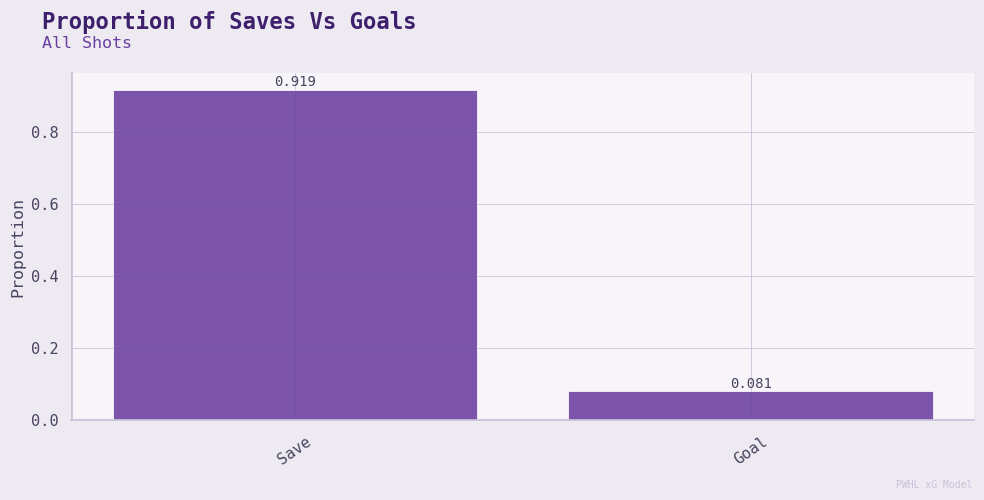

In [21]:
rates = df['is_goal'].value_counts(normalize=True).sort_index()
rates.index = ['Save', 'Goal']

pwhl_bar(data=rates,
         title="Proportion of Saves Vs Goals",
         subtitle="All Shots",
         ylabel="Proportion")

Unsurprisingly, goals are relatively rare from a statistical point of view.  Some consideration to balance this data during modelling may be considered.

In [22]:
categorical_cols = ['pwhl', 'home_team', 'away_team', 'home_team_skaters', 'away_team_skaters',
                   'home_score', 'away_score', 'goal_diff', 'losing', 'tied', 'winning',
                   'skater_diff', 'es', 'pp', 'sh', 'rebound', 'backhand', 'slap', 'snap', 'tip',
                   'wrist', 'slot', 'close_game', 'late_game', 'is_forward', 'period_1', 'period_2', 'period_3']

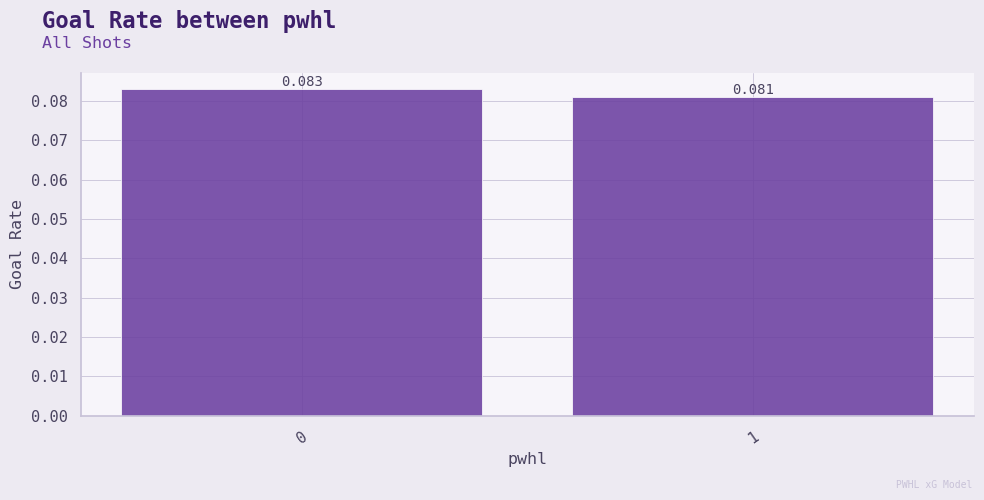

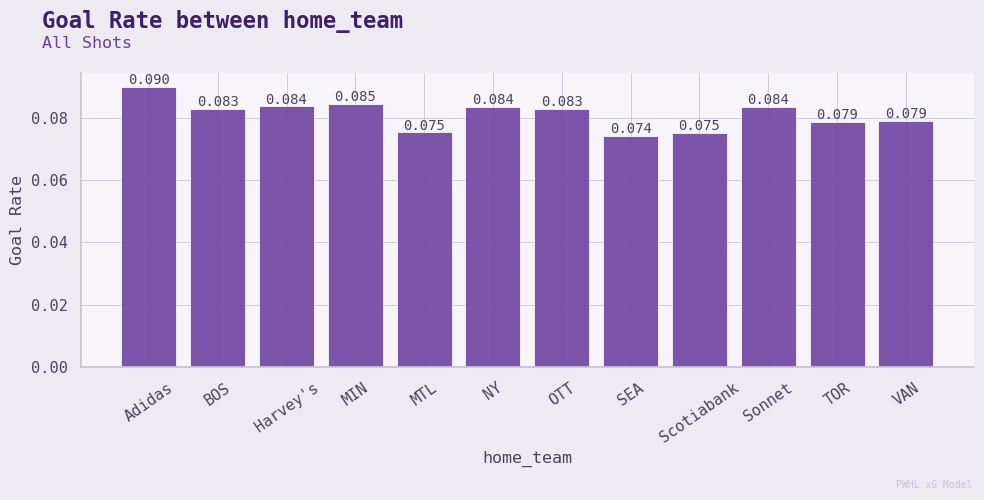

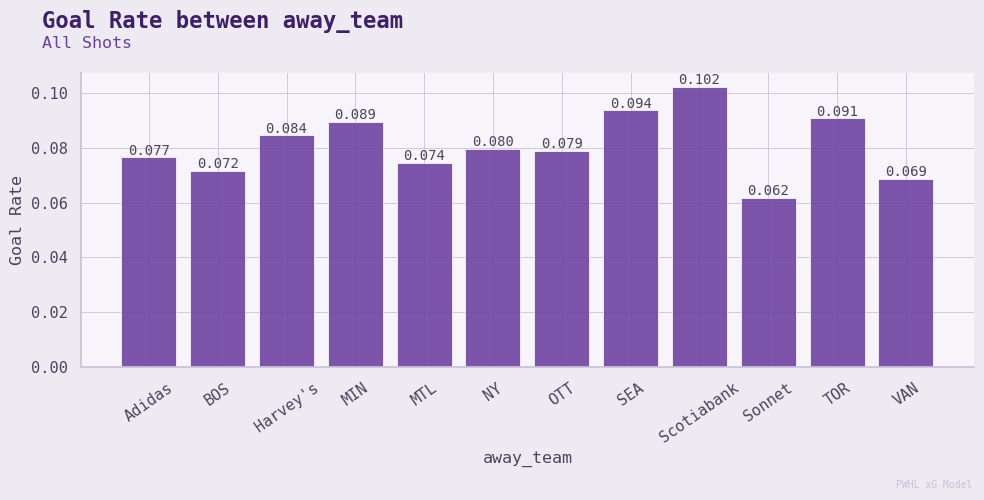

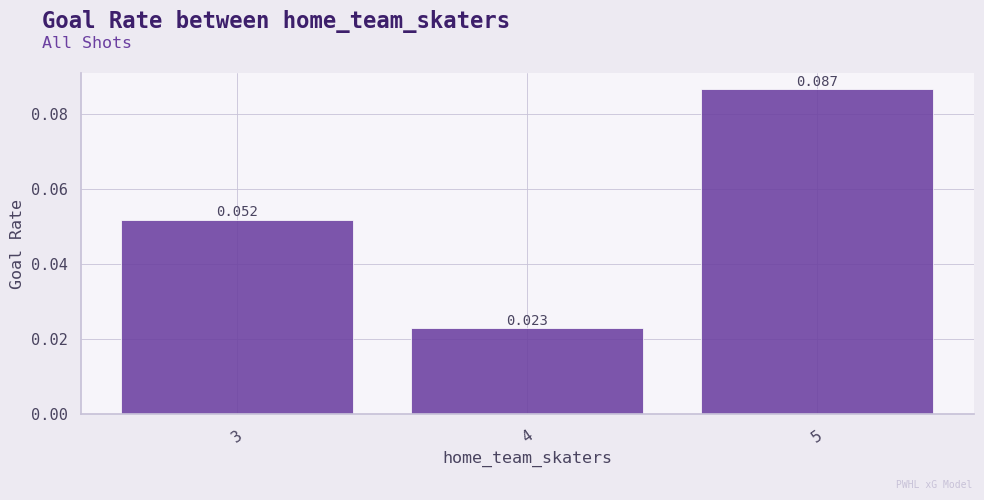

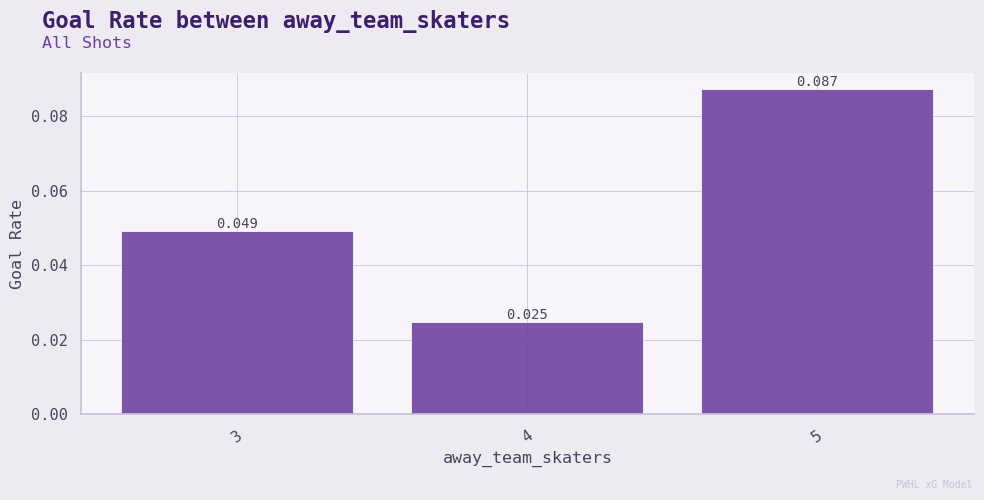

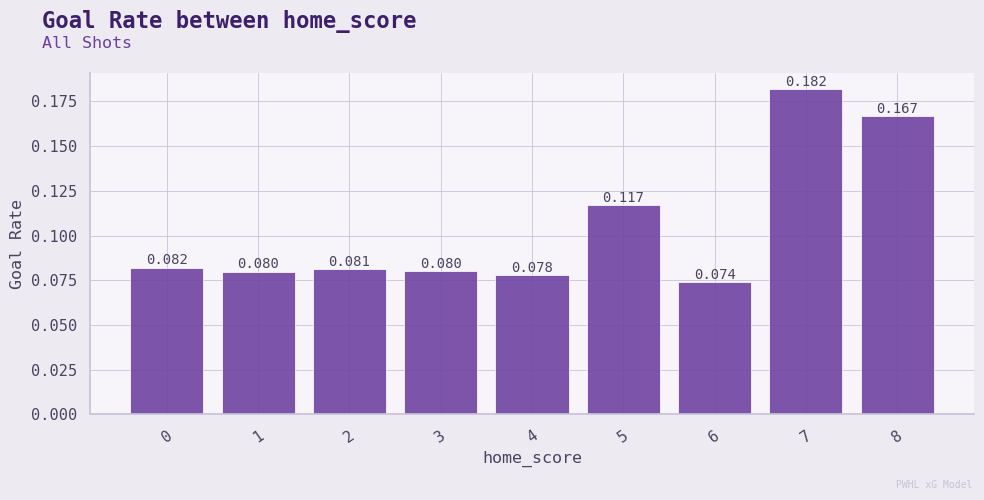

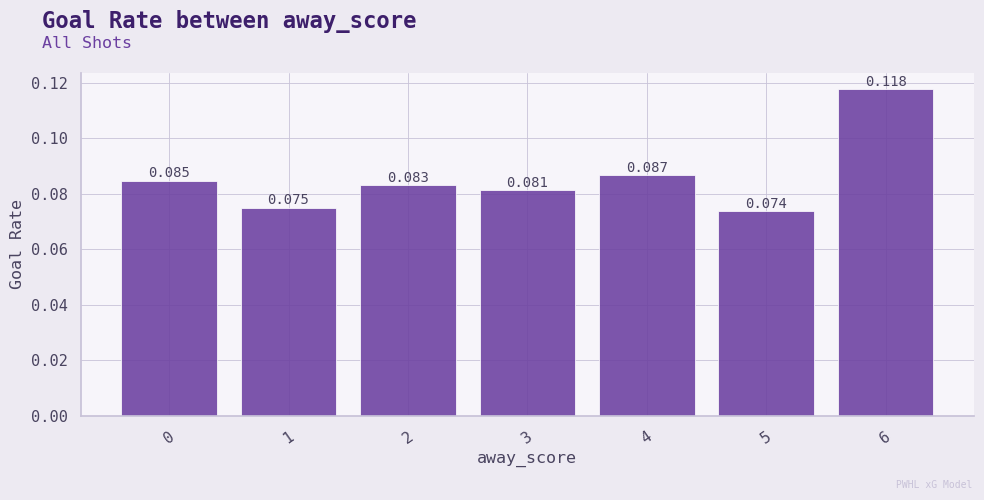

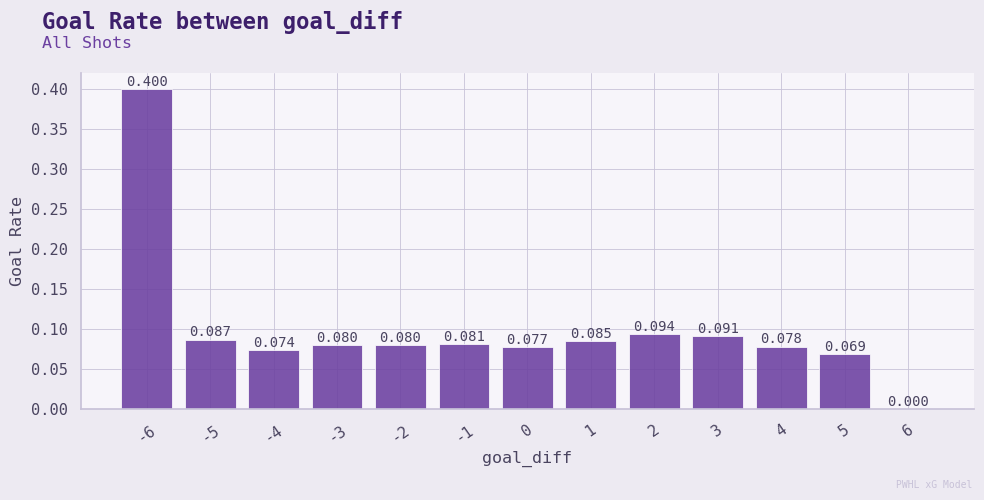

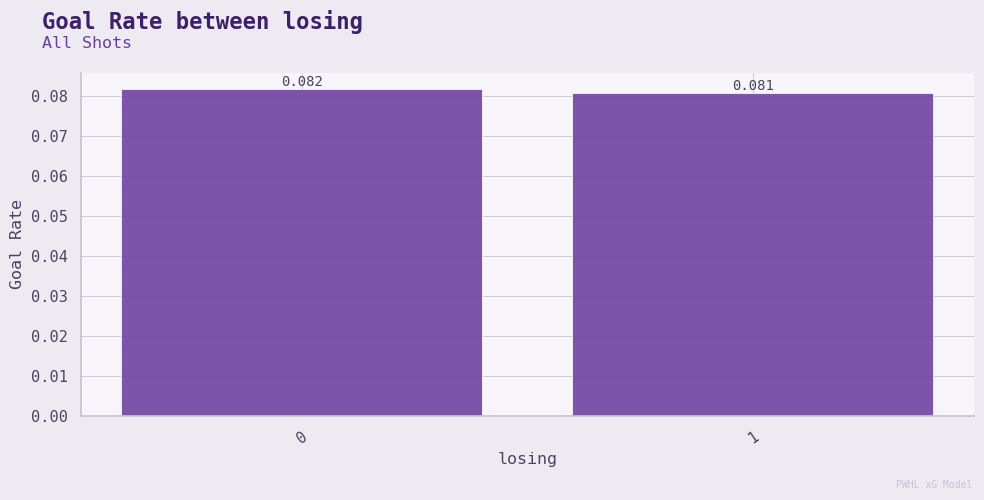

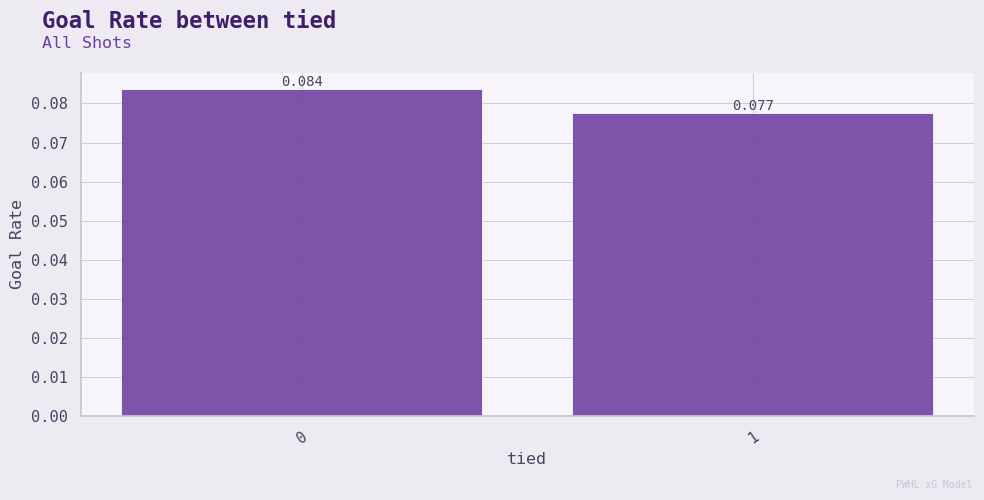

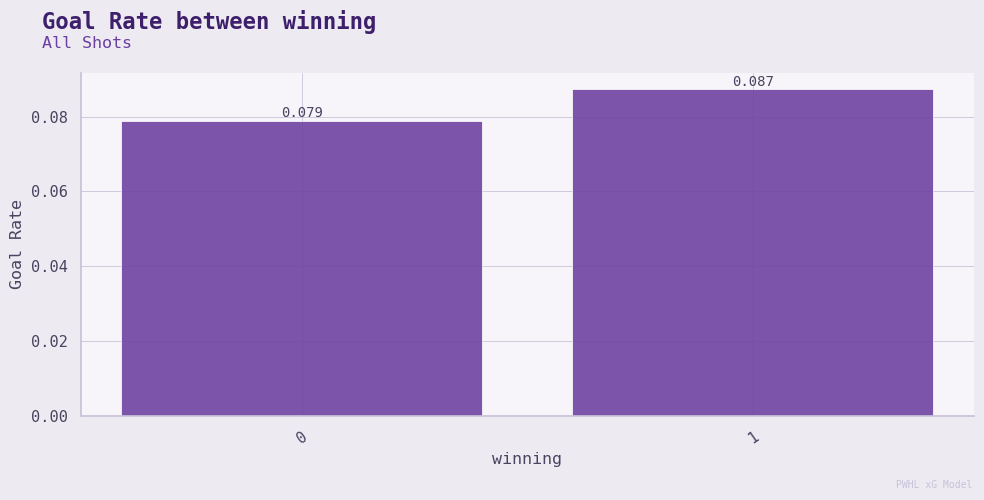

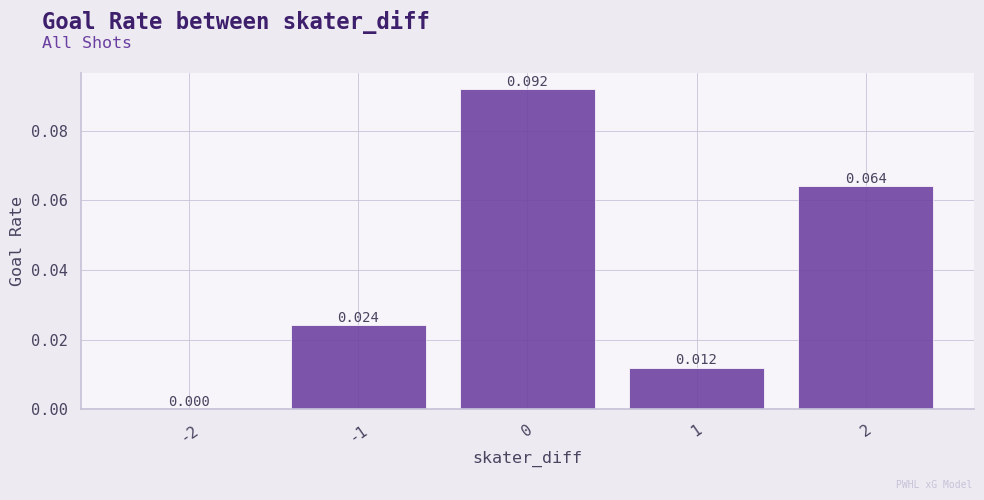

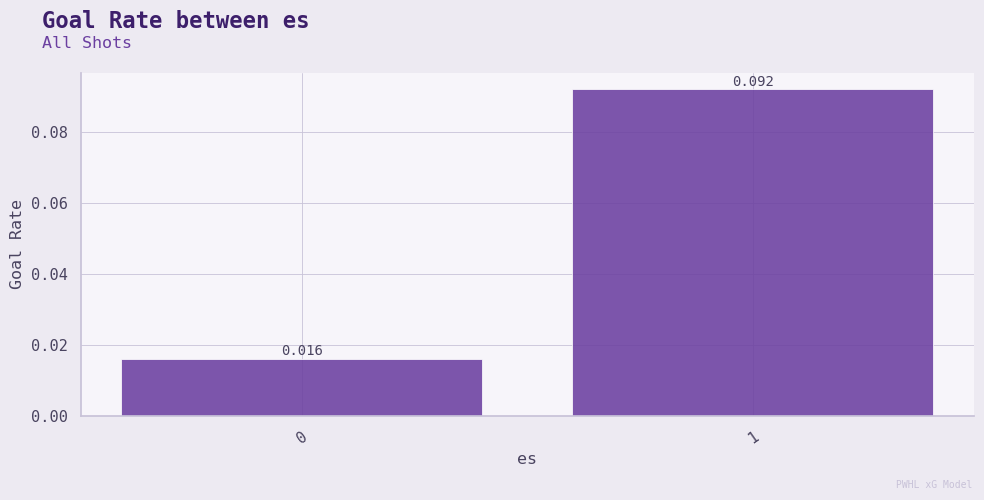

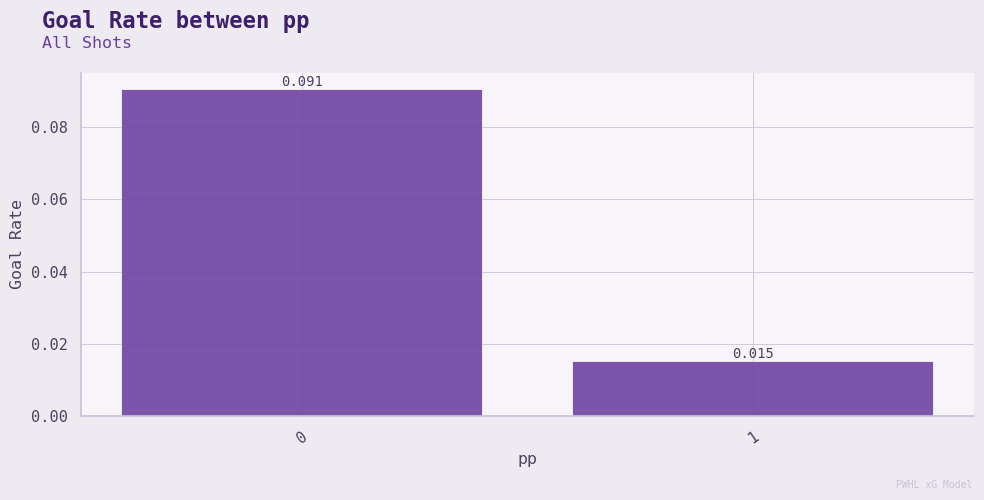

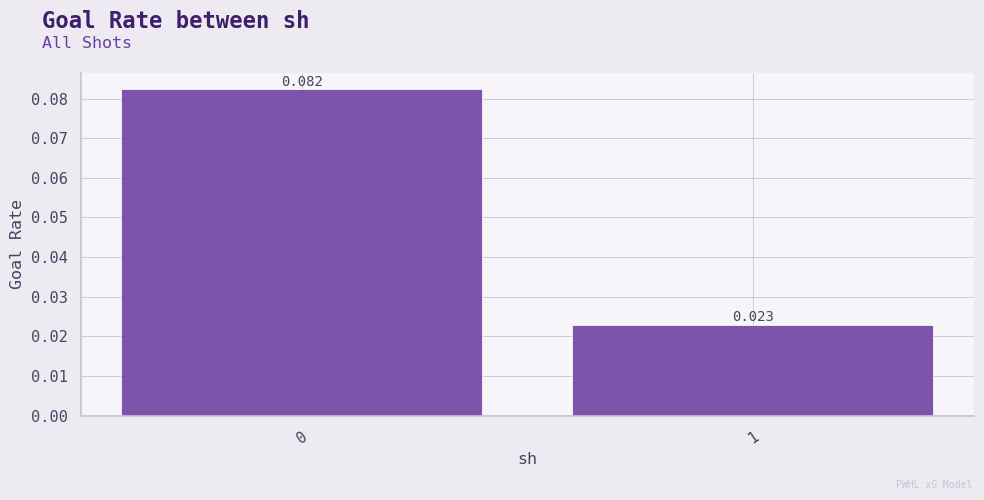

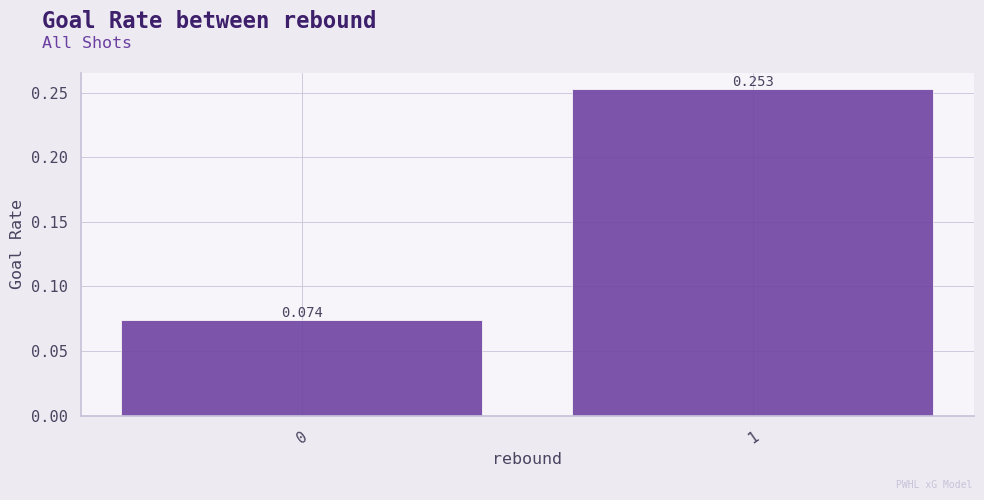

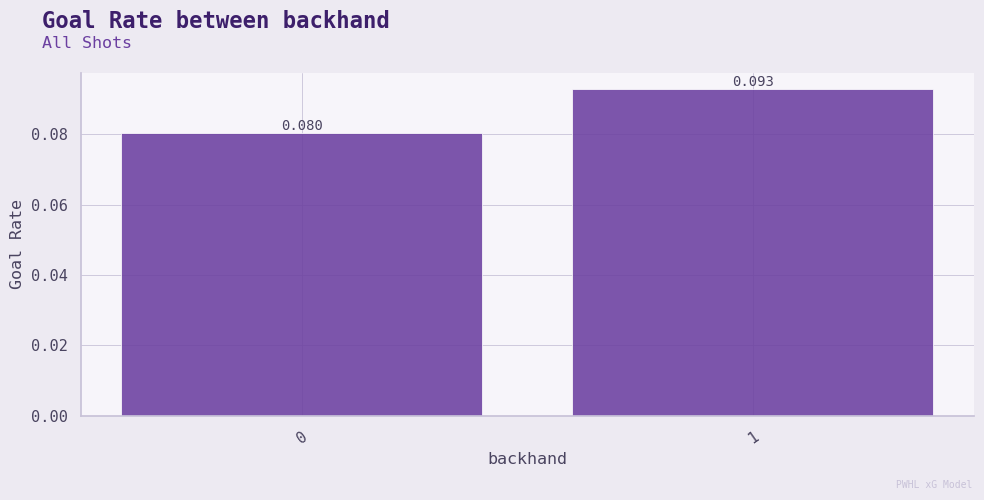

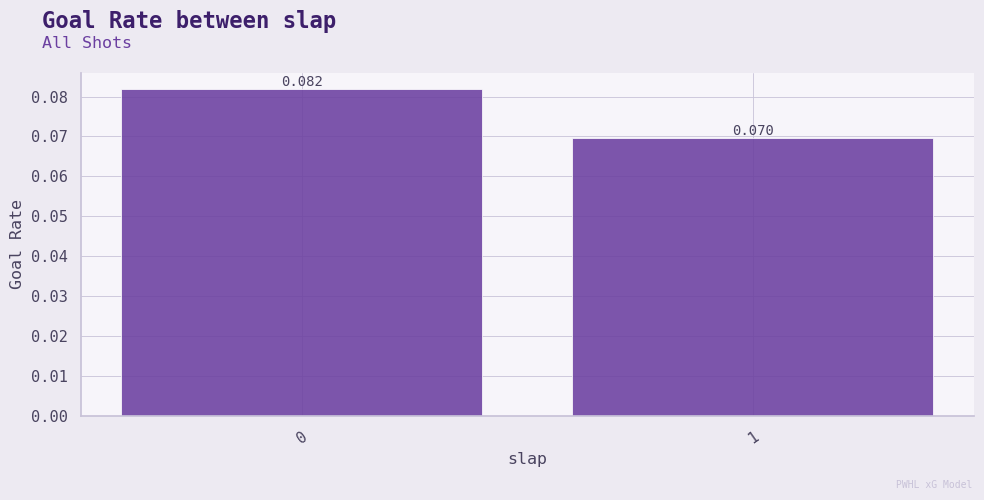

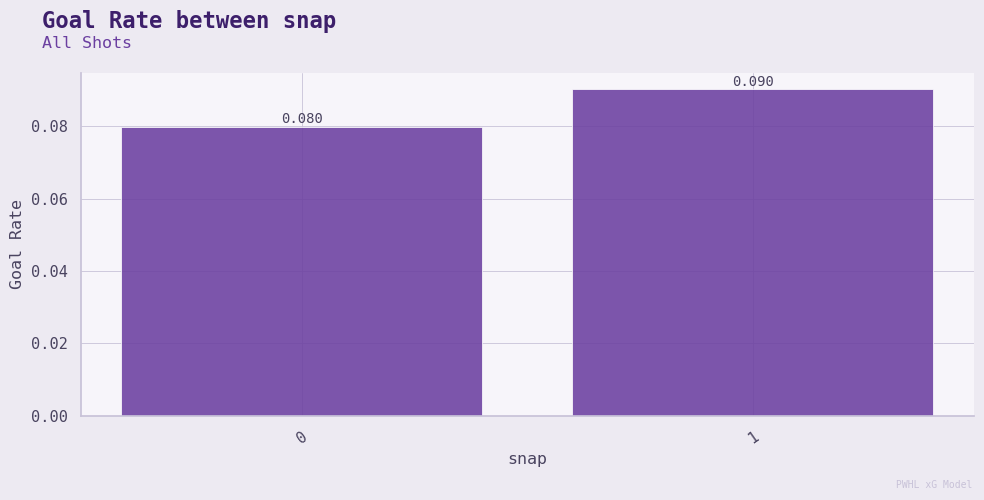

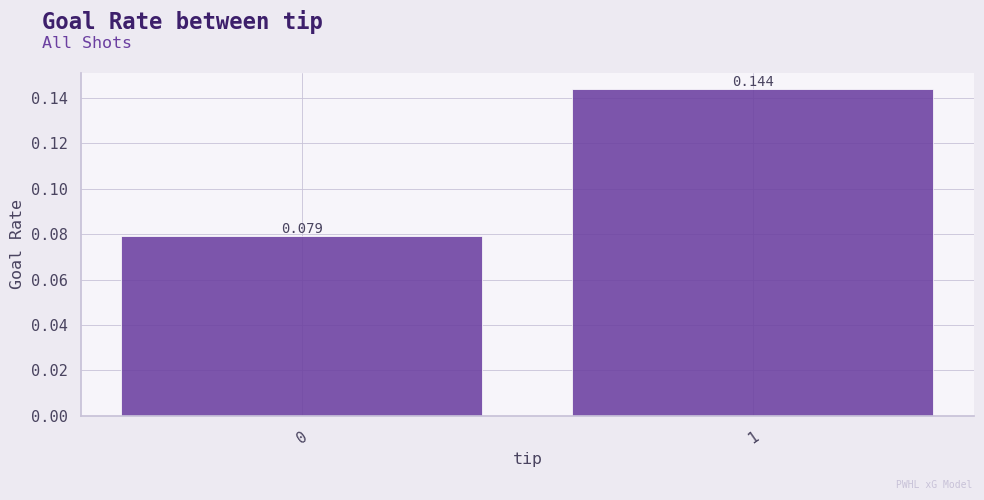

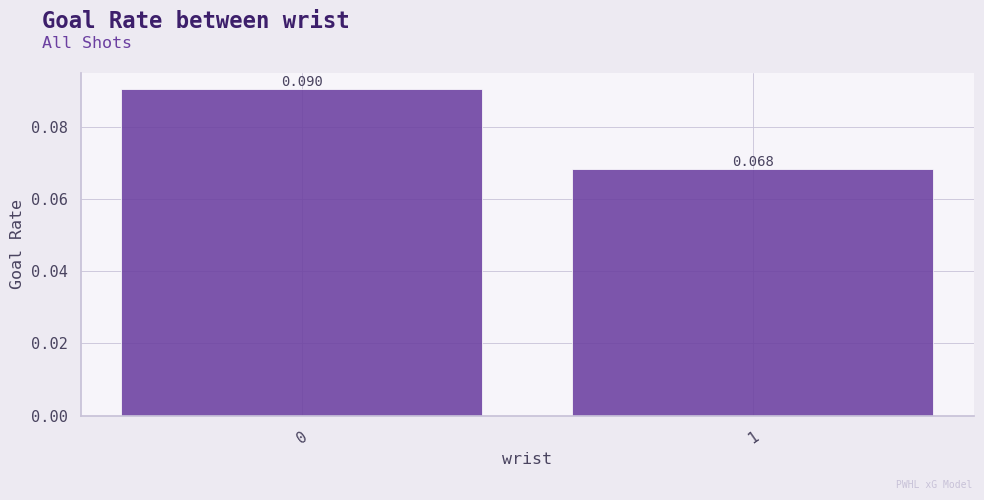

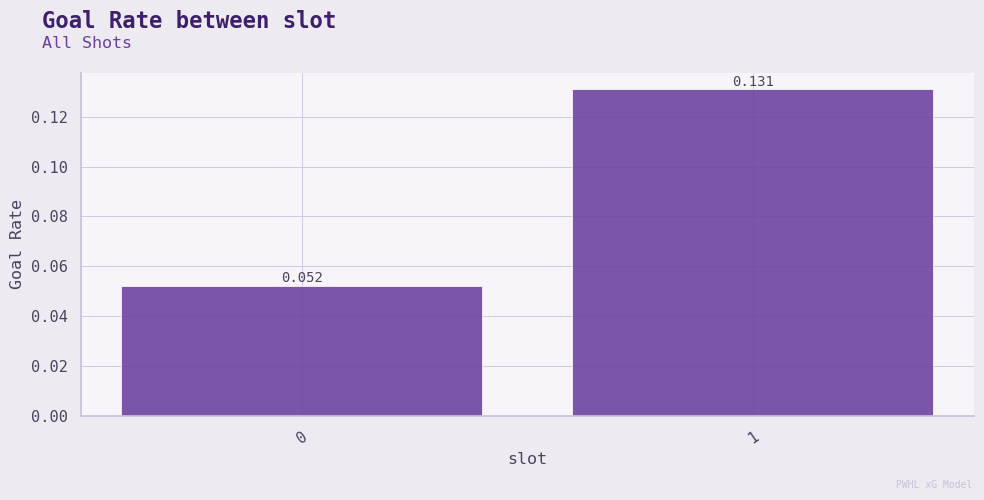

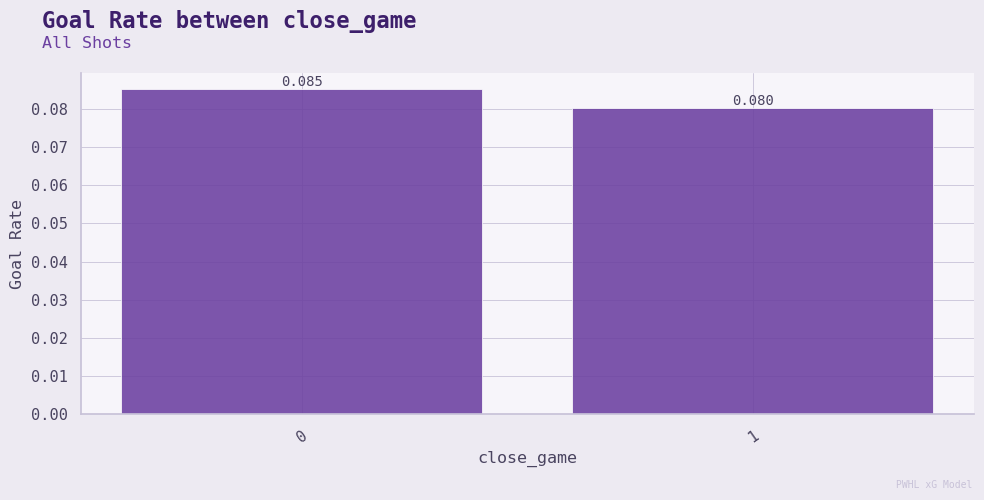

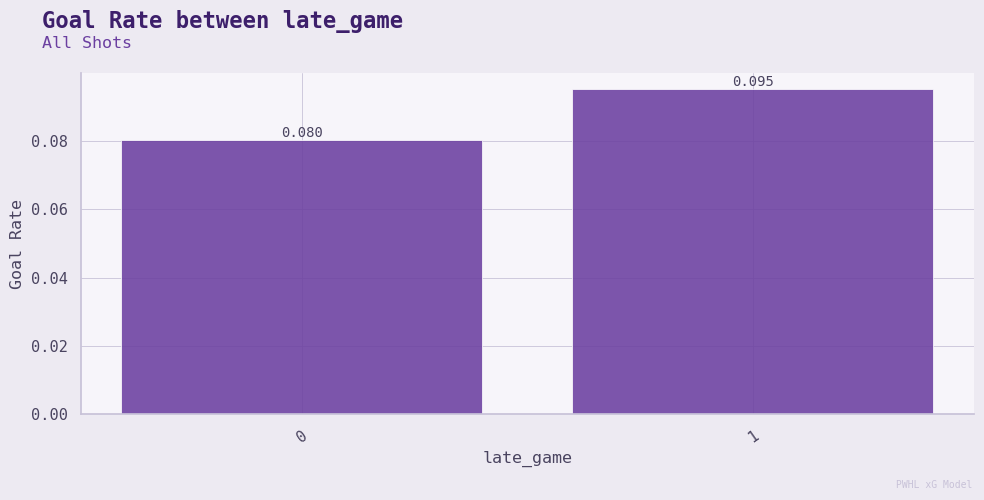

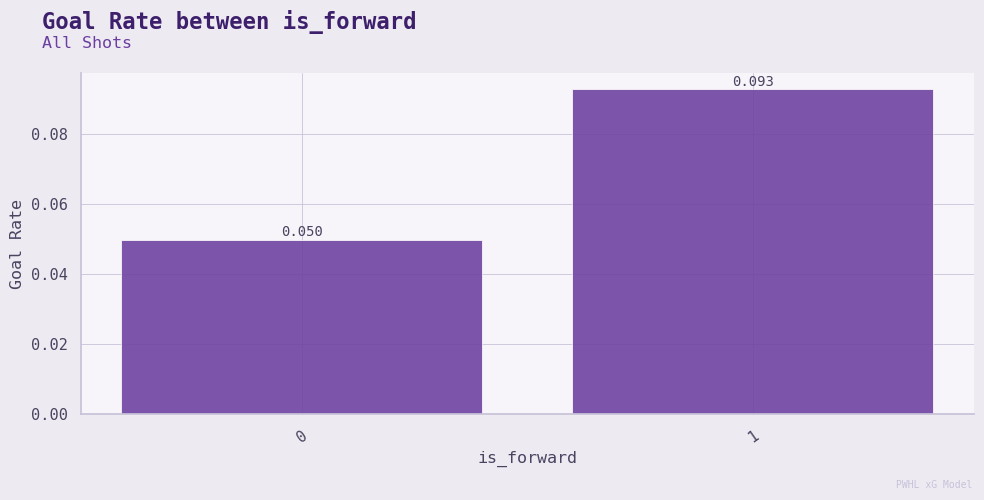

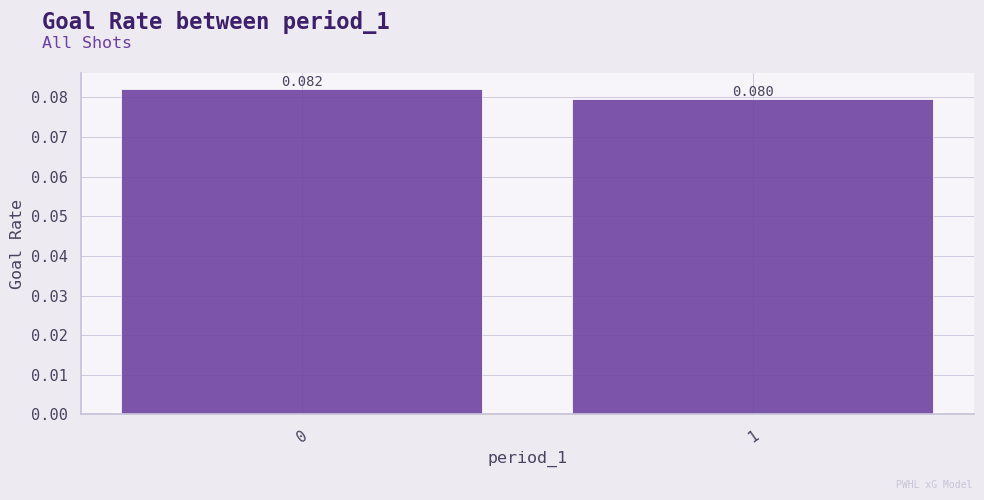

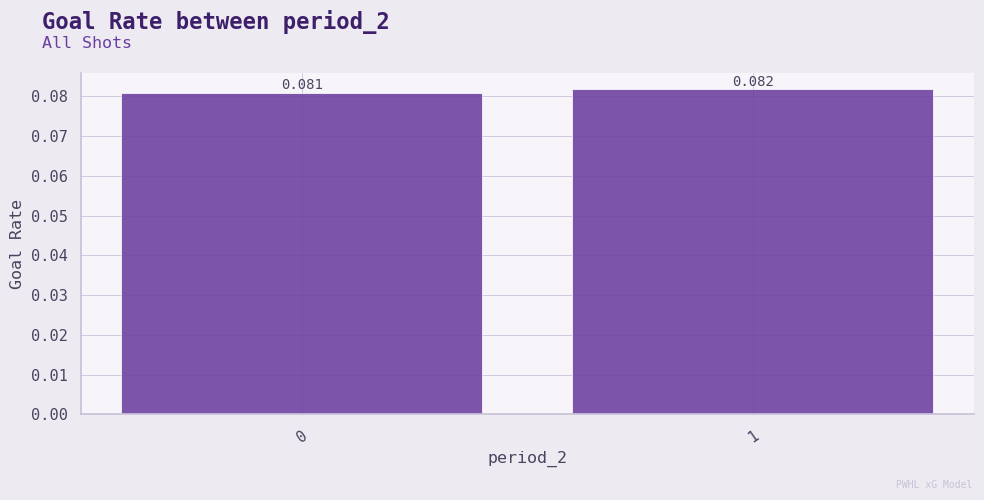

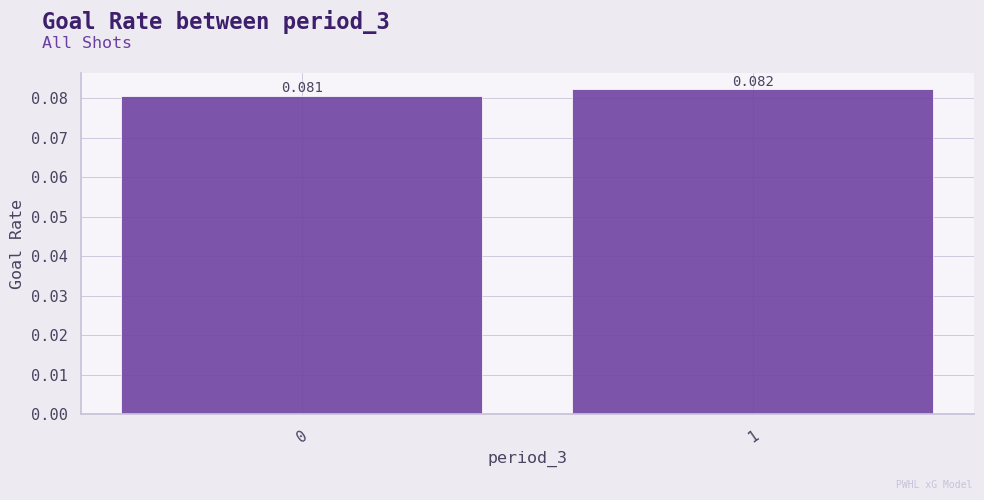

In [23]:
for col in categorical_cols:
    pwhl_bar(df=df,
             x=col,
             y='is_goal',
             title=f"Goal Rate between {col}",
             xlabel=f"{col}",
             ylabel="Goal Rate",
             subtitle="All Shots",
             horizontal = False,
            show = True)

### Categorical Data Impressions

The goal rate between the leagues is close, supporting the use of all shots from both leagues.

The goal rate increases later in the game, in the 3rd period and during `late_game`.

The goal rate is slightly higher when the team is leading than when the team is trailing.  This could suggest that 'good teams are better' and show that the better team will not just get the lead but extend it.

`rebound` look to be one of the strongest indicators for goal rate, so the change in methodology did not negatively impact this feature.

`slot` shots also seem to be one of the strongest predictors, which is unsurprising but looks to be helpful for the modelling.

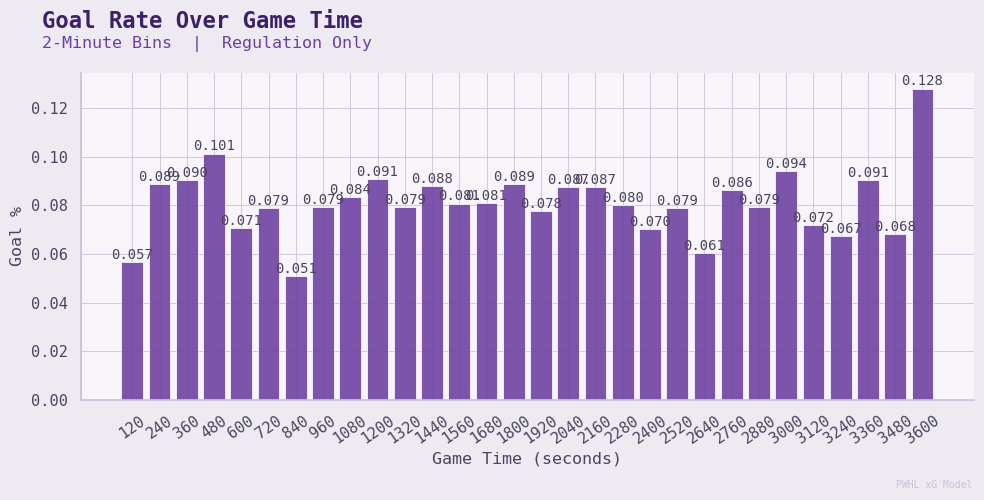

In [24]:
df['game_time_bin'] = pd.cut(df['game_time'], bins=range(0, 3601, 120), 
                              labels=range(120, 3601, 120))
goal_rate = df.groupby('game_time_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate Over Game Time",
         subtitle="2-Minute Bins  |  Regulation Only",
         xlabel="Game Time (seconds)",
         ylabel="Goal %")

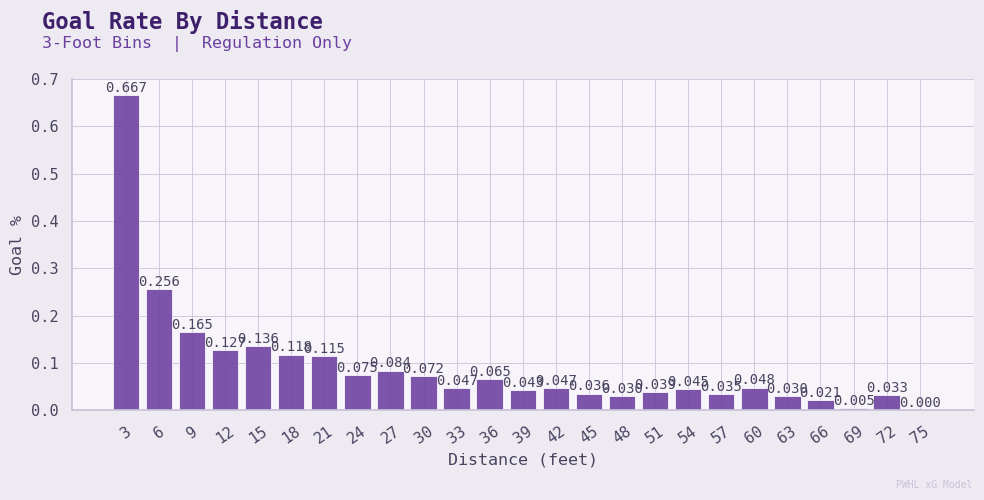

In [25]:
df['distance_bin'] = pd.cut(df['dist_ft'], bins=range(0, 76, 3), 
                              labels=range(3, 76, 3))
goal_rate = df.groupby('distance_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Distance",
         subtitle="3-Foot Bins  |  Regulation Only",
         xlabel="Distance (feet)",
         ylabel="Goal %")

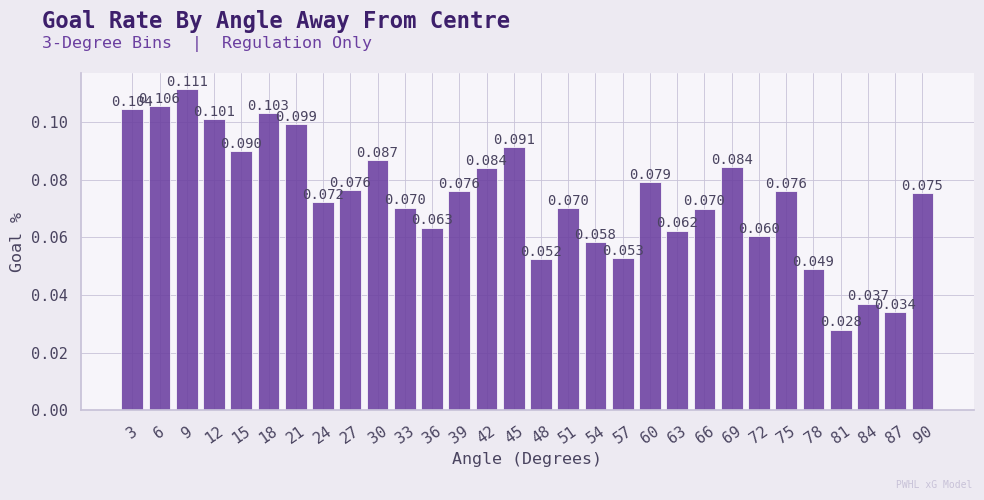

In [26]:
df['angle_bin'] = pd.cut(df['angle_deg'], bins=range(0, 91, 3), 
                              labels=range(3, 91, 3))
goal_rate = df.groupby('angle_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Angle Away From Centre",
         subtitle="3-Degree Bins  |  Regulation Only",
         xlabel="Angle (Degrees)",
         ylabel="Goal %")

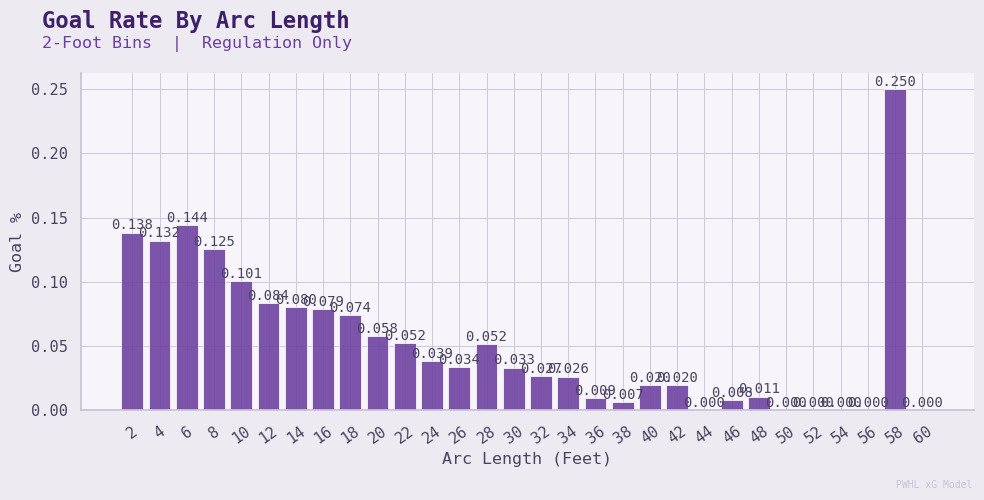

In [27]:
df['arclength_bin'] = pd.cut(df['arclength'], bins=range(0, 61, 2), 
                              labels=range(2, 61, 2))
goal_rate = df.groupby('arclength_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Arc Length",
         subtitle="2-Foot Bins  |  Regulation Only",
         xlabel="Arc Length (Feet)",
         ylabel="Goal %")

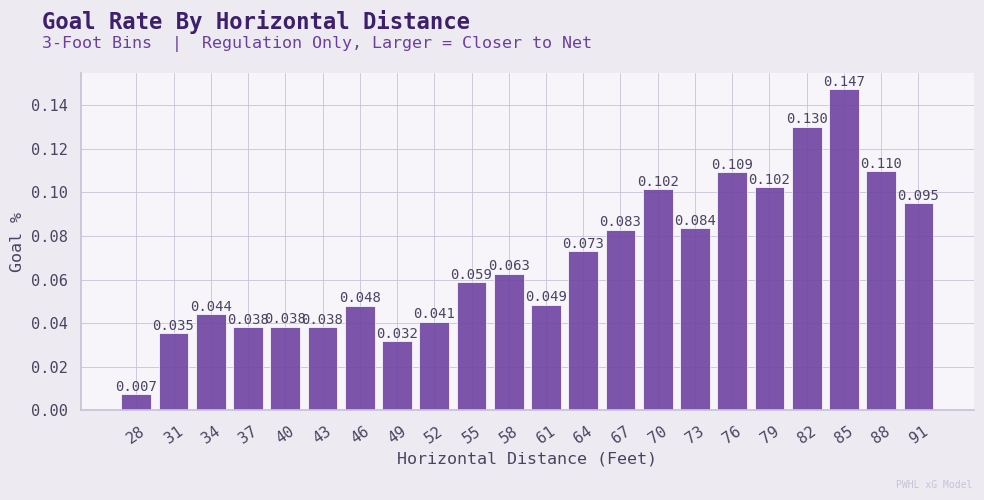

In [28]:
df['x_bin'] = pd.cut(df['x_ft'], bins=range(25, 93, 3), 
                              labels=range(28, 93, 3))
goal_rate = df.groupby('x_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Horizontal Distance",
         subtitle="3-Foot Bins  |  Regulation Only, Larger = Closer to Net",
         xlabel="Horizontal Distance (Feet)",
         ylabel="Goal %")

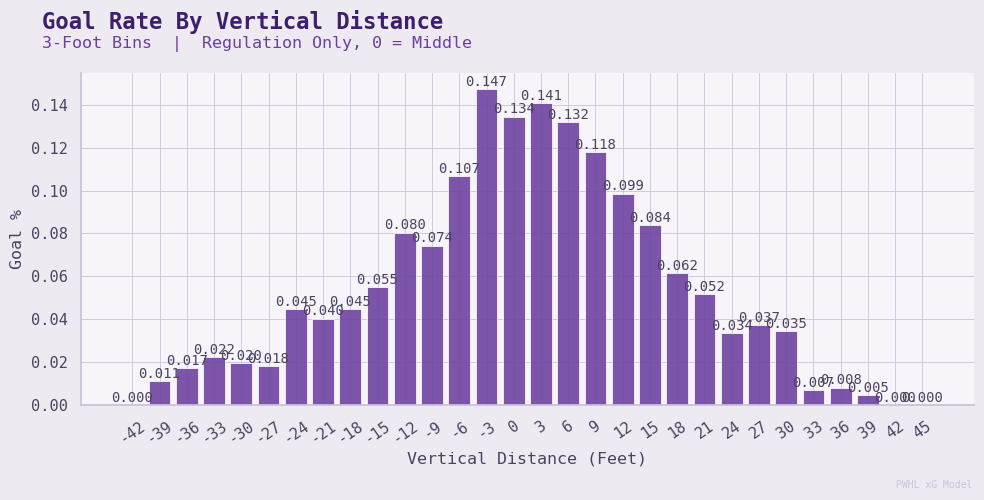

In [29]:
df['y_bin'] = pd.cut(df['y_ft'], bins=range(-45, 46, 3), 
                              labels=range(-42, 46, 3))
goal_rate = df.groupby('y_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Vertical Distance",
         subtitle="3-Foot Bins  |  Regulation Only, 0 = Middle",
         xlabel="Vertical Distance (Feet)",
         ylabel="Goal %")

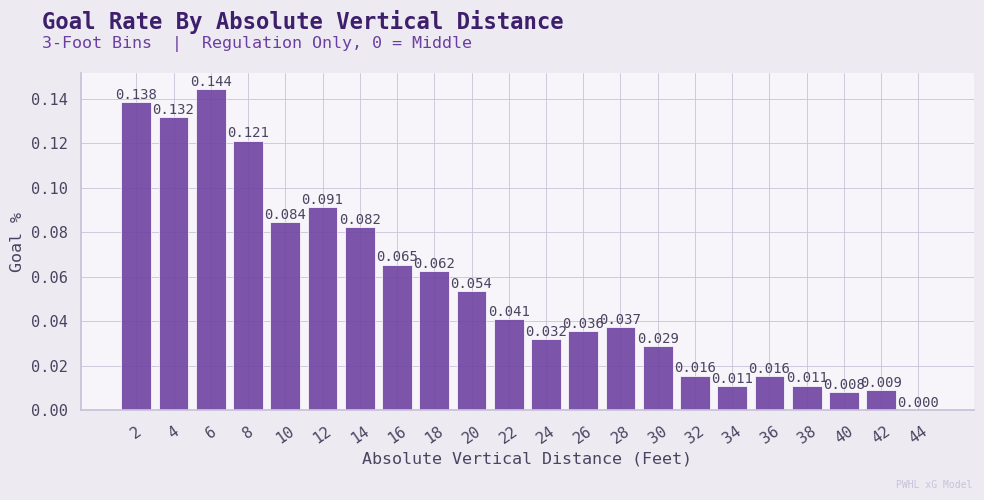

In [30]:
df['y_abs_bin'] = pd.cut(df['y_abs'], bins=range(0, 46, 2), 
                              labels=range(2, 46, 2))
goal_rate = df.groupby('y_abs_bin')['is_goal'].mean()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Absolute Vertical Distance",
         subtitle="3-Foot Bins  |  Regulation Only, 0 = Middle",
         xlabel="Absolute Vertical Distance (Feet)",
         ylabel="Goal %")

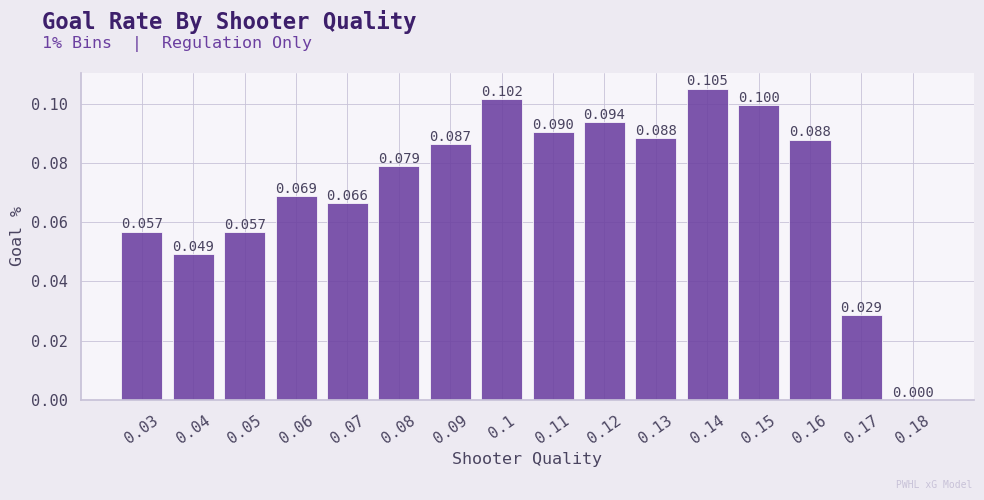

In [31]:
bins = np.arange(0, df['shooter_quality'].max() + 0.01, 0.01)
labels = np.round(bins[1:], 3)

df['shoot_qual_bin'] = pd.cut(df['shooter_quality'], bins=bins, labels=labels)

goal_rate = df.groupby('shoot_qual_bin')['is_goal'].mean().dropna()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Shooter Quality",
         subtitle="1% Bins  |  Regulation Only",
         xlabel="Shooter Quality",
         ylabel="Goal %")

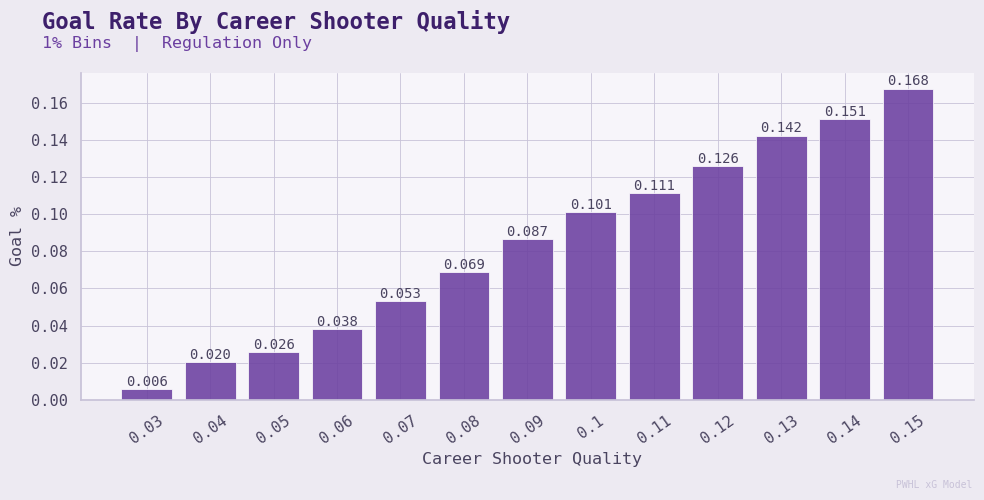

In [32]:
bins = np.arange(0, df['shooter_career_quality'].max() + 0.01, 0.01)
labels = np.round(bins[1:], 3)

df['shoot_career_bin'] = pd.cut(df['shooter_career_quality'], bins=bins, labels=labels)

goal_rate = df.groupby('shoot_career_bin')['is_goal'].mean().dropna()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Career Shooter Quality",
         subtitle="1% Bins  |  Regulation Only",
         xlabel=" Career Shooter Quality",
         ylabel="Goal %")

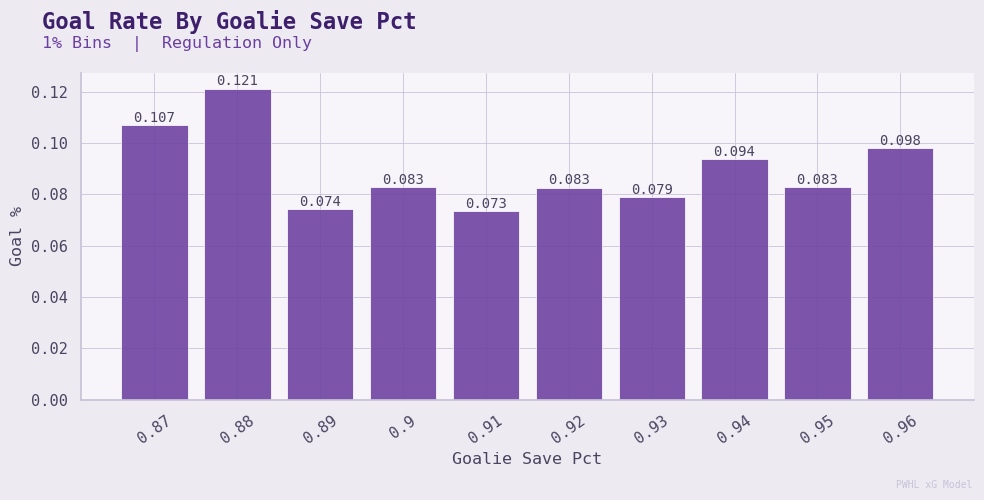

In [33]:
bins = np.arange(0, df['goalie_save_pct'].max() + 0.01, 0.01)
labels = np.round(bins[1:], 3)

df['goalie_pct_bin'] = pd.cut(df['goalie_save_pct'], bins=bins, labels=labels)

goal_rate = df.groupby('goalie_pct_bin')['is_goal'].mean().dropna()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Goalie Save Pct",
         subtitle="1% Bins  |  Regulation Only",
         xlabel="Goalie Save Pct",
         ylabel="Goal %")

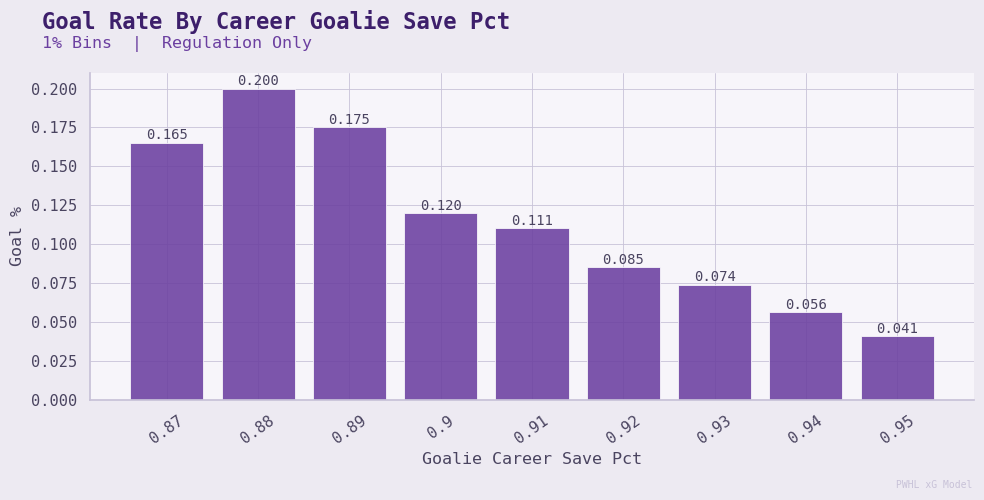

In [34]:
bins = np.arange(0, df['goalie_career_save_pct'].max() + 0.01, 0.01)
labels = np.round(bins[1:], 3)

df['goalie_career_bin'] = pd.cut(df['goalie_career_save_pct'], bins=bins, labels=labels)

goal_rate = df.groupby('goalie_career_bin')['is_goal'].mean().dropna()

pwhl_bar(data=goal_rate,
         title="Goal Rate By Career Goalie Save Pct",
         subtitle="1% Bins  |  Regulation Only",
         xlabel="Goalie Career Save Pct",
         ylabel="Goal %")

### Numerical Data Impressions

Some aspects are not that surprising, shorter `dist_ft`, `arclength` and `y_abs` all look to have linear coorelations to `is_goal`.

`game_time` does not have much effect EXCEPT for when it is really late in the game.  Unfortunately, this could be an indiciation of the increased number of chances when a goalie is pulled in addition to late game fatigue.

When looking for the quality of shooter and goalies, the end result of the Bayesian process giving `shooter_career_quality` and `goalie_career_save_pct` seemed to be better indicators than the 'rolling' `skater_quality` and `goalie_save_pct`.

In [35]:
corr = df.corr(numeric_only=True)['is_goal']
corr_filtered = corr[corr.abs() > 0.05].drop('is_goal').sort_values()
print(corr_filtered)

y_abs                    -0.157207
dist_ft                  -0.156845
arclength                -0.155020
pp                       -0.090792
skater_diff              -0.066669
angle_deg                -0.051989
goalie_career_save_pct   -0.050972
home_team_skaters         0.061185
away_team_skaters         0.062323
is_forward                0.069337
es                        0.096813
x_ft                      0.119767
rebound                   0.127780
shooter_career_quality    0.131425
slot                      0.139163
Name: is_goal, dtype: float64


### Correlation Impressions

Location data (`x_ft`, `dist_ft`, `arclength`, `y_abs`) as well as `slot` all seem to be strong indicators, suggesting the location of the shot may be the most important in determine the success.

In addition, `rebound` and `shooter_career_quality` also seem to have strong correlations.

These features may be a good starting point for the simplest version of a model.

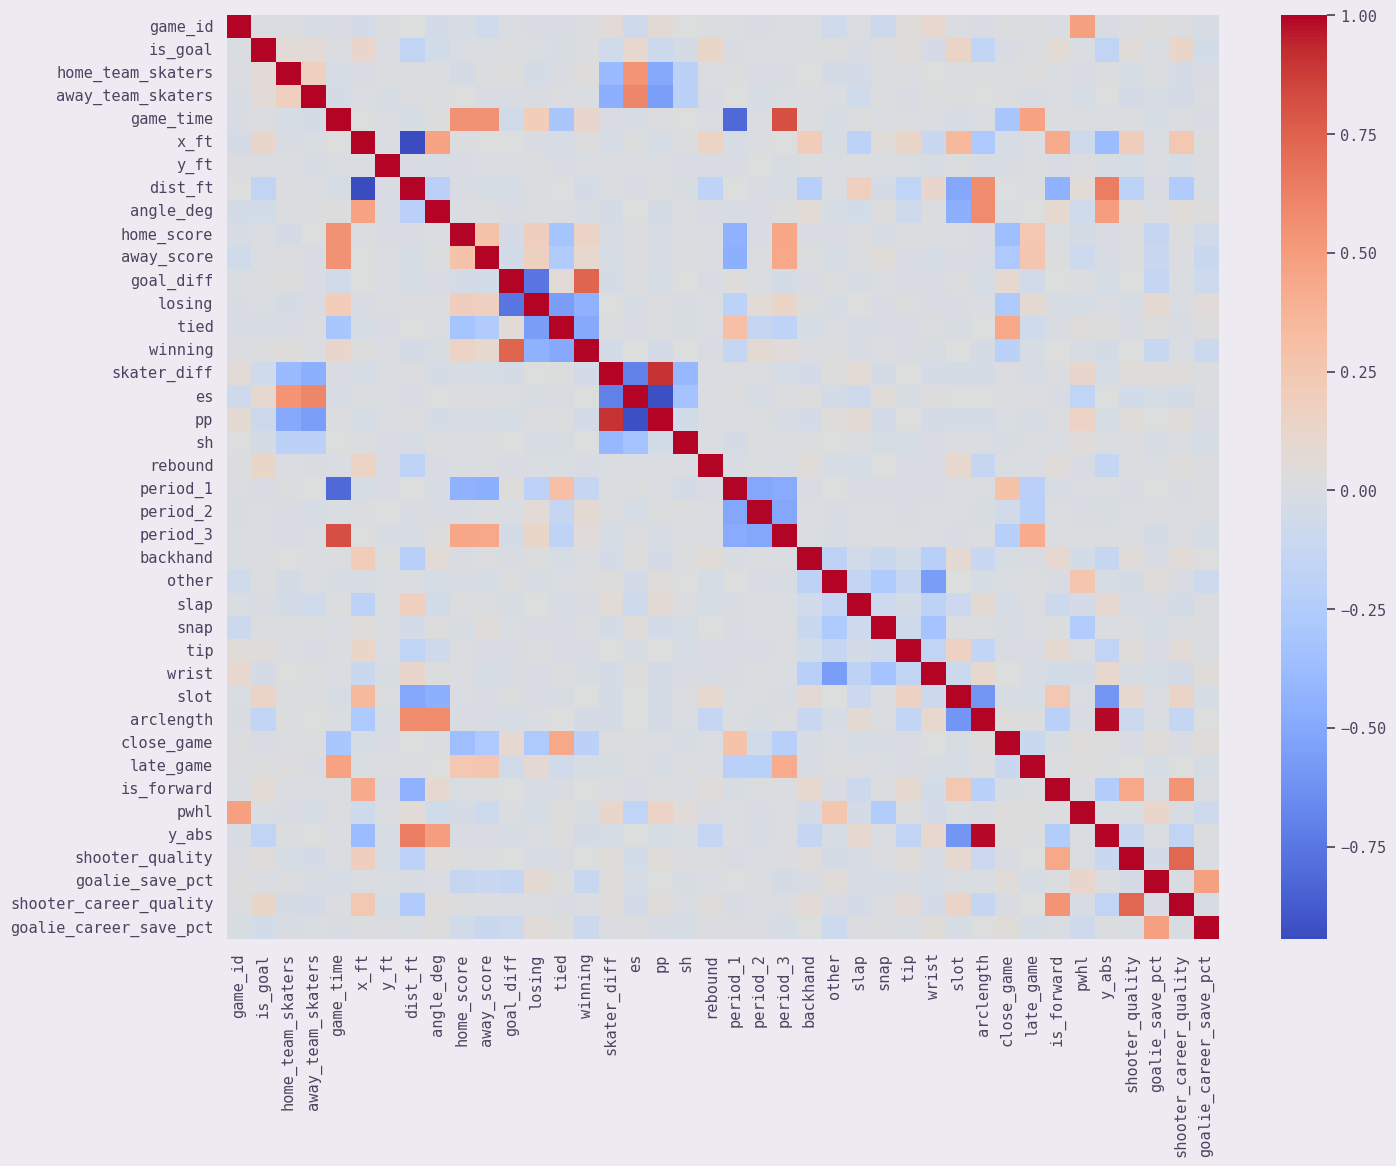

In [36]:
plt.figure(figsize = (16, 12))
sns.heatmap(data = df.corr(numeric_only = True),cmap = 'coolwarm')
plt.show()

Mostly uncorrelated which is good, but dist_ft and arc_length are one of most correlated, so we'll take a closer look.

In [37]:
corr_matrix = df.corr(numeric_only=True)
pairs = []
for i, col_a in enumerate(corr_matrix.columns):
    for col_b in corr_matrix.columns[i+1:]:
        r = corr_matrix.loc[col_a, col_b]
        if abs(r) > 0.5:
            pairs.append((col_a, col_b, round(r, 3)))

pairs_df = pd.DataFrame(pairs, columns=['feature_a', 'feature_b', 'correlation'])
pairs_df = pairs_df.sort_values('correlation', key=abs, ascending=False)
print(pairs_df.to_string(index=False))

        feature_a              feature_b  correlation
        arclength                  y_abs        0.988
             x_ft                dist_ft       -0.945
               es                     pp       -0.923
      skater_diff                     pp        0.907
        game_time               period_3        0.812
        game_time               period_1       -0.811
        goal_diff                 losing       -0.760
        goal_diff                winning        0.734
  shooter_quality shooter_career_quality        0.728
      skater_diff                     es       -0.700
          dist_ft                  y_abs        0.640
             slot              arclength       -0.602
away_team_skaters                     es        0.601
             slot                  y_abs       -0.597
        angle_deg              arclength        0.578
          dist_ft              arclength        0.569
           losing                   tied       -0.561
            other           

### Colinearity Impressions

`arclength` seems to be very correlated to all of the location data, but especially `y_abs`.  It could be argued that you could choose `arclength` by itself for a very simple model OR including all of the location data, but should not include `arclength` with it.  The visualization below highlights this issue.

Not as strong, but `dist_ft` seems to have the same issue.  `x_ft`, `y_abs` may be good enough to start for the location of the shot for a simple model.

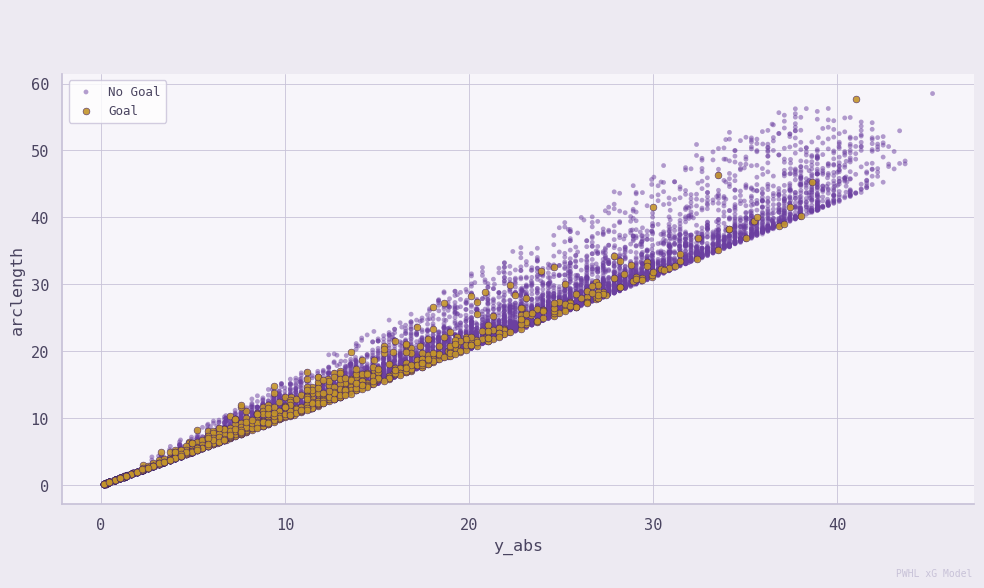

In [38]:
pwhl_scatter(df = df,
            x = 'y_abs',
            y = 'arclength',
            color_by = 'is_goal')

<a id = 'prepping'></a>

## 4. Prep Data for Modelling

In [40]:
model_df = df[['home_team_skaters', 'away_team_skaters', 'period_1', 'period_2', 'period_3', 'game_time',
               'x_ft', 'y_ft', 'y_abs', 'dist_ft', 'angle_deg', 'arclength', 
               'shooter_quality', 'shooter_career_quality', 'goalie_save_pct', 'goalie_career_save_pct',
               'home_score', 'away_score', 'goal_diff', 'losing', 'tied', 'winning',
               'skater_diff', 'es', 'pp','sh','rebound', 'backhand', 'other', 'slap', 'snap', 'tip',
               'wrist', 'slot', 'close_game', 'late_game','is_forward', 'pwhl', 'is_goal']]

In [46]:
full_df = df[['game_id','player_name', 'player_team', 'goalie_name', 'goalie_team',
               'home_team_skaters', 'away_team_skaters', 'period_1', 'period_2', 'period_3', 'game_time',
               'x_ft', 'y_ft', 'y_abs', 'dist_ft', 'angle_deg', 'arclength', 
               'shooter_quality', 'shooter_career_quality', 'goalie_save_pct', 'goalie_career_save_pct',
               'home_score', 'away_score', 'goal_diff', 'losing', 'tied', 'winning',
               'skater_diff', 'es', 'pp','sh','rebound', 'backhand', 'other', 'slap', 'snap', 'tip',
               'wrist', 'slot', 'close_game', 'late_game','is_forward', 'pwhl', 'is_goal']]

We will keep all of the data for now, but a starting point for a simple model may include:

- `x_ft` or `dist_ft` (not both)
- `y_abs`
- `rebound`
- `slot`
- `career_skater_quality`
- `career_goalie_quality`

More complex models may be able to interpret more, but this will set an easily interpretable baseline to compare against.

In [41]:
model_df

,home_team_skaters,away_team_skaters,period_1,period_2,period_3,game_time,x_ft,y_ft,y_abs,dist_ft,angle_deg,arclength,shooter_quality,shooter_career_quality,goalie_save_pct,goalie_career_save_pct,home_score,away_score,goal_diff,losing,tied,winning,skater_diff,es,pp,sh,rebound,backhand,other,slap,snap,tip,wrist,slot,close_game,late_game,is_forward,pwhl,is_goal
0,5,5,1,0,0,30.266666,75.142281,15.844118,15.844118,21.0,48.8,17.886134,0.081256,0.061335,0.918744,0.926386,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,5,5,1,0,0,57.900000,81.272430,-0.252941,0.252941,7.7,1.9,0.255342,0.081256,0.071575,0.918744,0.911145,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0
2,5,5,1,0,0,134.866670,85.295959,-36.464706,36.464706,36.7,84.2,53.933117,0.081256,0.111090,0.920337,0.911145,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,5,5,1,0,0,298.133330,67.598160,0.252941,0.252941,21.4,0.7,0.261450,0.081256,0.099041,0.920337,0.926386,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
4,5,5,1,0,0,301.500000,43.458725,-32.444130,32.444130,55.9,35.5,34.635186,0.081256,0.085613,0.921869,0.926386,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,5,5,0,0,1,3041.000000,70.000000,-20.429825,20.429825,27.9,47.1,22.935197,0.093751,0.093751,0.891849,0.893416,3,1,-2,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
16684,4,5,0,0,1,3261.000000,71.333333,-0.447368,0.447368,17.7,1.5,0.463385,0.101462,0.101024,0.892377,0.893416,3,1,-2,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0
16685,4,5,0,0,1,3265.000000,75.000000,2.236842,2.236842,14.2,9.1,2.255314,0.101024,0.101024,0.892899,0.893416,3,1,-2,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0
16686,5,5,0,0,1,3341.000000,73.333333,5.517544,5.517544,16.6,19.4,5.620658,0.081869,0.081869,0.905829,0.905829,3,1,2,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0


In [42]:
model_df.to_csv('model_data.csv', index = False)

In [47]:
full_df.to_csv('player_data.csv', index = False)